In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
from matplotlib import pyplot as plt

2024-05-31 14:04:53.203821: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-31 14:04:53.233083: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-31 14:04:53.233135: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-31 14:04:53.233169: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-31 14:04:53.239488: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-31 14:04:53.240182: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

In [3]:
# mnist corresponds to federated emnist(only_digits=True)
train_ds, val_ds = tfds.load('mnist', split=['train[:80%]', 'train[80%:]'])
test_ds = tfds.load('mnist', split='test')
len(train_ds), len(val_ds), len(test_ds)

(48000, 12000, 10000)

2024-05-31 14:07:02.999482: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


(<matplotlib.image.AxesImage at 0x7981dc0d6490>,
 <tf.Tensor: shape=(), dtype=int64, numpy=4>)

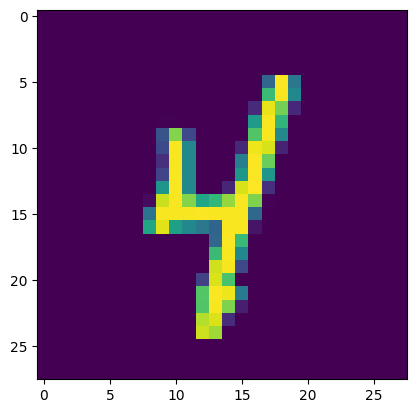

In [4]:
ex = next(iter(train_ds))
plt.imshow(ex['image']), ex['label']

In [12]:
ex['image'].numpy().max()  # pixels should be scaled down between 0 and 1

255

In [14]:
def preprocess_ds(ds, is_train=False):
    def element_fn(element):
        image = element['image']
        label = element['label']
        image = tf.cast(image, dtype=tf.float32) / 255.  # rescale image
        return (image, label)
    
    if is_train:
        return (
            ds
            .map(element_fn)
            .shuffle(128)
            .batch(512)  # just increasing the batch size improved the training process a lot idk why
        )
    else:
        return (
            ds
            .map(element_fn)
            .batch(512)
        )

In [15]:
train = preprocess_ds(train_ds, is_train=True)
val = preprocess_ds(val_ds)
test = preprocess_ds(test_ds)

In [23]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation=tf.nn.relu),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(10),
])

loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

model.compile(
    optimizer=optimizer, 
    loss=loss_object, 
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy')]
)

In [24]:
model.fit(train, epochs=10, validation_data=val)

Epoch 1/10
94/94 [==============================] - 11s 113ms/step - loss: 0.7626 - accuracy: 0.7657 - val_loss: 0.2253 - val_accuracy: 0.9343
Epoch 2/10
94/94 [==============================] - 11s 115ms/step - loss: 0.2073 - accuracy: 0.9373 - val_loss: 0.1230 - val_accuracy: 0.9638
Epoch 3/10
94/94 [==============================] - 11s 114ms/step - loss: 0.1357 - accuracy: 0.9585 - val_loss: 0.0926 - val_accuracy: 0.9722
Epoch 4/10
94/94 [==============================] - 11s 115ms/step - loss: 0.1073 - accuracy: 0.9669 - val_loss: 0.0736 - val_accuracy: 0.9773
Epoch 5/10
94/94 [==============================] - 11s 114ms/step - loss: 0.0915 - accuracy: 0.9712 - val_loss: 0.0643 - val_accuracy: 0.9808
Epoch 6/10
94/94 [==============================] - 11s 114ms/step - loss: 0.0784 - accuracy: 0.9753 - val_loss: 0.0559 - val_accuracy: 0.9832
Epoch 7/10
94/94 [==============================] - 11s 115ms/step - loss: 0.0699 - accuracy: 0.9783 - val_loss: 0.0524 - val_accuracy: 0.9843

In [25]:
model.evaluate(test)

20/20 [==============================] - 1s 25ms/step - loss: 0.0382 - accuracy: 0.9873


[0.0381569005548954, 0.9872999787330627]